# Histopathologic Cancer Detection
Cancer detection is an important area in the field of biomedical data science. AI-assisted classification of tissues can help physicians detect cancerous tissues, preventing false negatives and speeding up medical diagnostics. Here, we utilize Convolutional Neural Networks (CNNs) to help classify the cancer tissue. We will train and evaluate a number of CNN architectures. In consideration of time and resources, architectures may be implemented in a slightly modified form.
1. A **VGG-16** architecture strings together 2 convolutions with 3x3 filters and a 2x2 max pool and 3 convolutions with 3x3 filters and another 2x2 max pool. The output is then fed to multiple dense layers for classification.<br>
    ![VGG-16](../assets/vgg-16.png)
2. An **AlexNet** architectures begins with an 11x11 convolutional filter followed by a 3x3 max pool. This is followed by a smaller, 5x5 convolution and another 3x3 max pool. Last, a series of 3 3x3 convolutions is followed by a final 3x3 max pool. For classification, multiple dense layers follow.<br>
    ![AlexNet](../assets/alex-net.png)
3. The simpler **LeNet-5** architecture uses strings together 2 5x5 convolutional layers followed by a 2x2 avg pool. For classification, it is followed by several dense layers.<br>
    ![LeNet-5](../assets/le-net.png)
    
To manage the machine-learning lifecycle, we will use [MLFlow](https://www.mlflow.org/docs/latest/index.html) for end-to-end machine-learning lifecylces, from inception, to deployment. This allows us to track our models and experiments, build machine-learning pipelines, among much more.

## Data Source and Ingestion
A script is provided in `src/pipeline/data-ingestion.sh` for loading the data. This utilizes the Kaggle CLI to download the data, then simply unzips it into the the `src/data/` directory. All in all, it contains a training and a testing set. The entire file structure is shown belown
```
.
├── assets
└── src
    ├── data
    │   ├── test
    │   └── train
    └── pipeline
```

## Prerequisites: Packages and Gloabl Settings

In [1]:
import numpy as np
import random
import os

from PIL import Image

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras

np.set_printoptions(precision=3)

print(tf.config.list_physical_devices('GPU'))

[]


2022-09-01 20:34:45.011749: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1900] Ignoring visible gpu device (device: 0, name: NVIDIA GeForce GTX 680, pci bus id: 0000:01:00.0, compute capability: 3.0) with Cuda compute capability 3.0. The minimum required Cuda capability is 3.5.


## Exploratory Data Analysis
Here, we will examine the training set to better understand the structure and patterns in the data.

In [117]:
# Obtain relevant paths
DIR_SRC = os.getcwd()
DIR_DATA = f"{DIR_SRC}/data"
DIR_DATA_TRAIN = f"{DIR_DATA}/train"
DIR_DATA_TEST = f"{DIR_DATA}/test"

In [118]:
# Obtain a list of all training and test files
FILES_DATA_TRAIN = [f"{DIR_DATA_TRAIN}/{a}" for a in os.listdir(DIR_DATA_TRAIN) if os.path.isfile(os.path.join(DIR_DATA_TRAIN, a))]
FILES_DATA_TEST = [f"{DIR_DATA_TEST}/{a}" for a in os.listdir(DIR_DATA_TEST) if os.path.isfile(os.path.join(DIR_DATA_TEST, a))]

print(f"Number of Training Images: {len(FILES_DATA_TRAIN)}")
print(f"Number of Testing Images:  {len(FILES_DATA_TEST)}")

Number of Training Images: 220025
Number of Testing Images:  57458


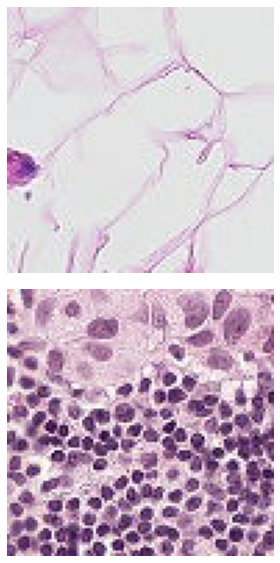

In [119]:
def display_images(image_files:list[str], n:int):
    n_images = len(image_files)
    image_indices = random.sample(range(n_images), n)
    
    image_list = []
    for a in image_indices:
        image = Image.open(image_files[a])
        image_array = np.array(image)
        image_list.append(image_array)
    
    # Display the images
    fig, ax = plt.subplots(nrows=n, ncols=1, figsize=(4, n*4), tight_layout=True)
    for i, a in enumerate(image_list):
        ax[i].imshow(a)
        ax[i].axis("off")

display_images(FILES_DATA_TRAIN, 2)

In [95]:
# To ensure there are no errors, we can open each image and retrieve the indices of those who fail
def grab_errors(image_files:list[str]):
    errors = []
    for i, a in enumerate(image_files):
        try:
            Image.open(a)
        except Exception as error:
            errors.append({
                "index": i,
                "file": a,
                "error_message": error
            })
    
    return errors
    
training_errors = grab_errors(FILES_DATA_TRAIN)
testing_errors = grab_errors(FILES_DATA_TEST)

In [96]:
print("Training Data Errors:")
for a in training_errors:
    print(f"Index:   {a['index']}")
    print(f"File:    {a['file']}")
    print(f"Message: {a['error_message']}\n")
    
print("Testing Data Errors:")
for a in testing_errors:
    print(f"Index:   {a['index']}")
    print(f"File:    {a['file']}")
    print(f"Message: {a['error_message']}\n")

Training Data Errors:
Testing Data Errors:


Image Dimension:   (96, 96, 3)
Train Image Count: 220025
Test Image Count:  57458


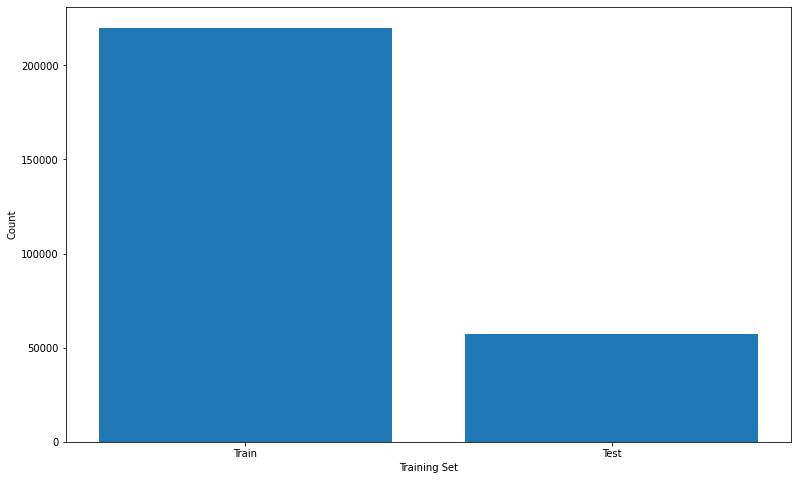

In [120]:
# Let's review the dimension of the images. They should all be the same
im = Image.open(FILES_DATA_TRAIN[0])
im_array = np.array(im)
print(f"Image Dimension:   {im_array.shape}")
print(f"Train Image Count: {len(FILES_DATA_TRAIN)}")
print(f"Test Image Count:  {len(FILES_DATA_TEST)}")

fig, ax = plt.subplots(figsize=(13, 8))
ax.bar(x=[0, 1], height=[len(FILES_DATA_TRAIN), len(FILES_DATA_TEST)])
ax.set_xlabel("Training Set")
ax.set_ylabel("Count")
ax.set_xticks([0, 1], labels=["Train", "Test"])

## Model Building
Here, we will build each model individually and train them later. Models are built using the Keras backend API for Tensorflow. Initially, we create datasets to store the training and testing (validation sets. This allows us the create data input pipelines with which we can easily observations into our models.

In [126]:
def image_train_reader():
    for fname in FILES_DATA_TRAIN:
        image = np.array(Image.open(fname))
        yield image

tf.data.Dataset.from_generator(image_train_reader, output_types=tf.float32)

2022-09-01 20:01:42.159076: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-01 20:01:42.197479: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-09-01 20:01:42.201762: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-09-01 20:01:42.201786: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required

<FlatMapDataset element_spec=TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)>